In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Input,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Car Classification'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    seed=123,
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

Found 9900 files belonging to 33 classes.
Using 7920 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    seed=123,
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 9900 files belonging to 33 classes.
Using 1980 files for validation.


In [ ]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = (train_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))
val_ds = (val_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))

Best basic model

In [ ]:
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))

model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(33 , activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 112, 112, 16)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                 

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])

In [ ]:
hist = model.fit(train_ds,batch_size=64,epochs=20,validation_data=val_ds)

Epoch 1/20
124/124 [==============================] - 42s 323ms/step - loss: 3.1633 - accuracy: 0.1192 - val_loss: 2.7765 - val_accuracy: 0.2162
Epoch 2/20
124/124 [==============================] - 9s 72ms/step - loss: 2.5603 - accuracy: 0.2852 - val_loss: 2.4759 - val_accuracy: 0.3106
Epoch 3/20
124/124 [==============================] - 9s 71ms/step - loss: 2.2636 - accuracy: 0.3607 - val_loss: 2.2819 - val_accuracy: 0.3525
Epoch 4/20
124/124 [==============================] - 9s 71ms/step - loss: 2.0958 - accuracy: 0.4155 - val_loss: 2.1032 - val_accuracy: 0.4636
Epoch 5/20
124/124 [==============================] - 9s 71ms/step - loss: 1.9802 - accuracy: 0.4503 - val_loss: 2.2025 - val_accuracy: 0.4278
Epoch 6/20
124/124 [==============================] - 9s 71ms/step - loss: 1.9027 - accuracy: 0.4726 - val_loss: 2.0035 - val_accuracy: 0.4737
Epoch 7/20
124/124 [==============================] - 9s 71ms/step - loss: 1.8375 - accuracy: 0.4927 - val_loss: 1.9082 - val_accuracy: 0.48

In [ ]:
model.evaluate(train_ds), model.evaluate(val_ds)

31/31 [==============================] - 1s 32ms/step - loss: 1.2183 - accuracy: 0.6879


([1.2769659757614136, 0.6380050778388977],
 [1.218284249305725, 0.6878787875175476])

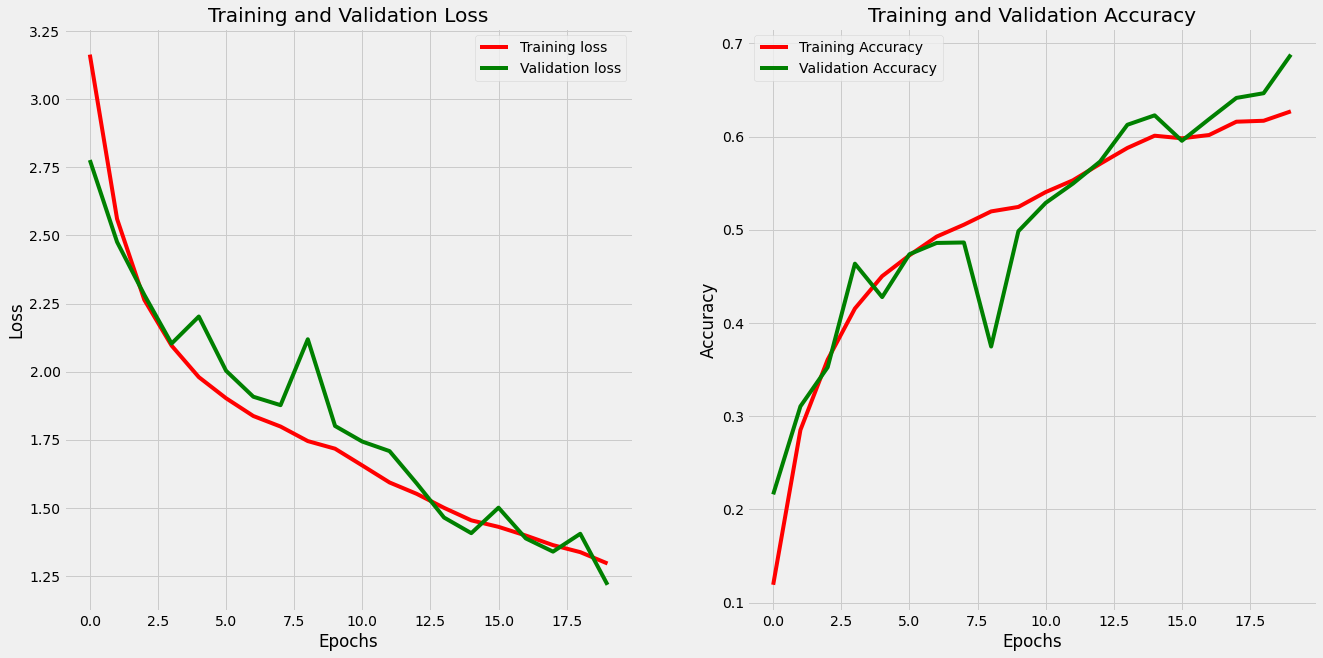

In [ ]:
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/basic_model_graph.jpg")

Best basic model을 base로 전이학습 실시 - 여기부터 진짜!

DenseNet121

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))

model.add(base_model)

model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(33 , activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 7, 16)          147472    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 4, 4, 16)          0         
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 4, 32)          4640      
                                                      

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])

In [ ]:
hist = model.fit(train_ds,batch_size=64,epochs=20,validation_data=val_ds)

Epoch 1/20
124/124 [==============================] - 119s 826ms/step - loss: 3.1697 - accuracy: 0.1021 - val_loss: 3.4452 - val_accuracy: 0.0909
Epoch 2/20
124/124 [==============================] - 93s 746ms/step - loss: 2.7575 - accuracy: 0.1535 - val_loss: 3.3265 - val_accuracy: 0.0157
Epoch 3/20
124/124 [==============================] - 93s 747ms/step - loss: 2.4367 - accuracy: 0.2298 - val_loss: 9.7786 - val_accuracy: 0.0000e+00
Epoch 4/20
124/124 [==============================] - 92s 744ms/step - loss: 2.2380 - accuracy: 0.2789 - val_loss: 3.8424 - val_accuracy: 0.0000e+00
Epoch 5/20
124/124 [==============================] - 92s 745ms/step - loss: 2.1090 - accuracy: 0.3157 - val_loss: 3.3958 - val_accuracy: 0.0000e+00
Epoch 6/20
124/124 [==============================] - 92s 746ms/step - loss: 1.9921 - accuracy: 0.3519 - val_loss: 3.5050 - val_accuracy: 0.0030
Epoch 7/20
124/124 [==============================] - 92s 746ms/step - loss: 1.8743 - accuracy: 0.3842 - val_loss: 6.

In [ ]:
model.evaluate(train_ds), model.evaluate(val_ds)

31/31 [==============================] - 5s 172ms/step - loss: 1.3065 - accuracy: 0.5404


([1.093975305557251, 0.6385101079940796],
 [1.306464672088623, 0.5404040217399597])

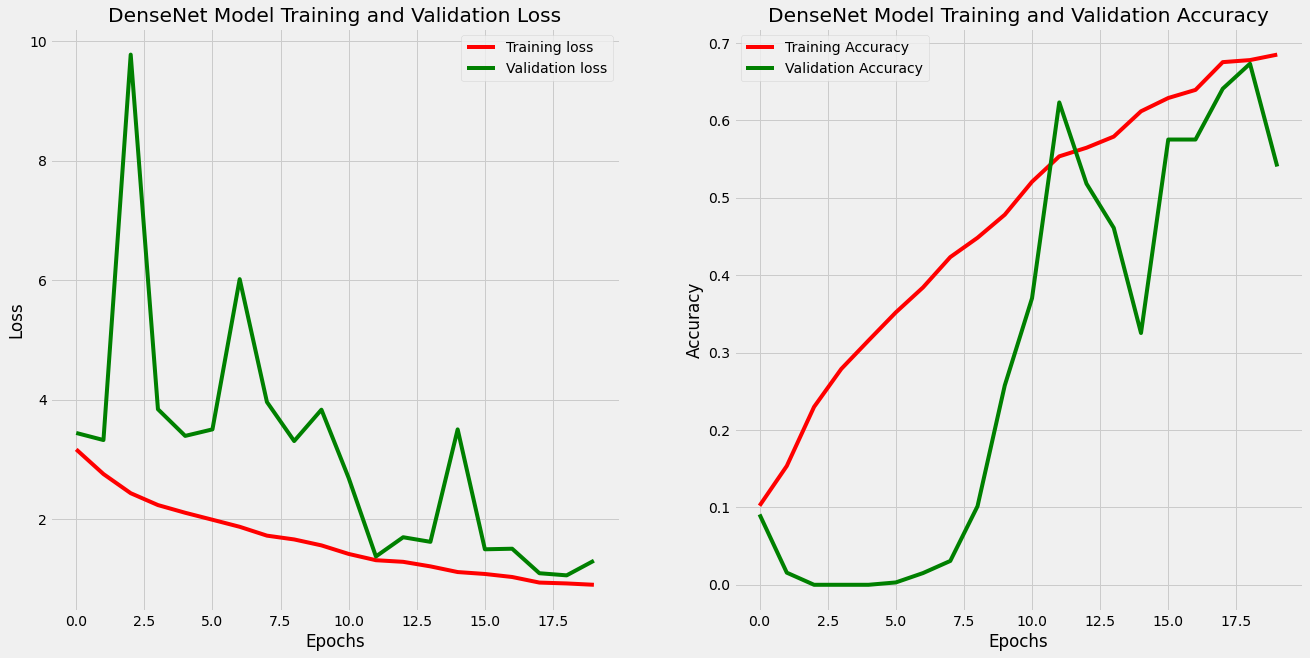

In [ ]:
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('DenseNet Model Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('DenseNet Model Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/DenseNet_model_graph.jpg")

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/DenseNet.keras')

MobileNet

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
num = 1
for layer in base_model.layers:
  if 'conv2d.Conv2D' in str(layer):
    print(layer, num)
  num += 1

<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47b4a61f0> 2
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47c78f550> 8
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47b4a9940> 15
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47c6c31f0> 21
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47c6c3d30> 28
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47c67f670> 34
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47c69af70> 41
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47c5b3b80> 47
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47c68ba30> 53
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47c5b3040> 59
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47c6784f0> 65
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47c5e2550> 71
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47c57d7c0> 78
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa47c59f070> 84


In [ ]:
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))

model.add(base_model)

model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(33 , activation = 'softmax'))

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, 
optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 16)          147472    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 16)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 4, 16)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 32)          4

In [ ]:
hist = model.fit(train_ds,batch_size=64,epochs=20,validation_data=val_ds)

Epoch 1/20
124/124 [==============================] - 3435s 26s/step - loss: 3.0808 - accuracy: 0.1277 - val_loss: 3.7143 - val_accuracy: 0.0000e+00
Epoch 2/20
124/124 [==============================] - 49s 391ms/step - loss: 2.3995 - accuracy: 0.2705 - val_loss: 3.3397 - val_accuracy: 0.1515
Epoch 3/20
124/124 [==============================] - 48s 387ms/step - loss: 2.0810 - accuracy: 0.3451 - val_loss: 3.4360 - val_accuracy: 0.1470
Epoch 4/20
124/124 [==============================] - 48s 386ms/step - loss: 1.8594 - accuracy: 0.3987 - val_loss: 3.8686 - val_accuracy: 0.0788
Epoch 5/20
124/124 [==============================] - 47s 381ms/step - loss: 1.6551 - accuracy: 0.4400 - val_loss: 3.2572 - val_accuracy: 0.1783
Epoch 6/20
124/124 [==============================] - 49s 392ms/step - loss: 1.5028 - accuracy: 0.4958 - val_loss: 2.1735 - val_accuracy: 0.3611
Epoch 7/20
124/124 [==============================] - 48s 386ms/step - loss: 1.3725 - accuracy: 0.5361 - val_loss: 1.6699 - va

In [ ]:
model.evaluate(train_ds), model.evaluate(val_ds)

31/31 [==============================] - 2s 75ms/step - loss: 0.3538 - accuracy: 0.8793


([0.5815984606742859, 0.8282828330993652],
 [0.3537856936454773, 0.879292905330658])

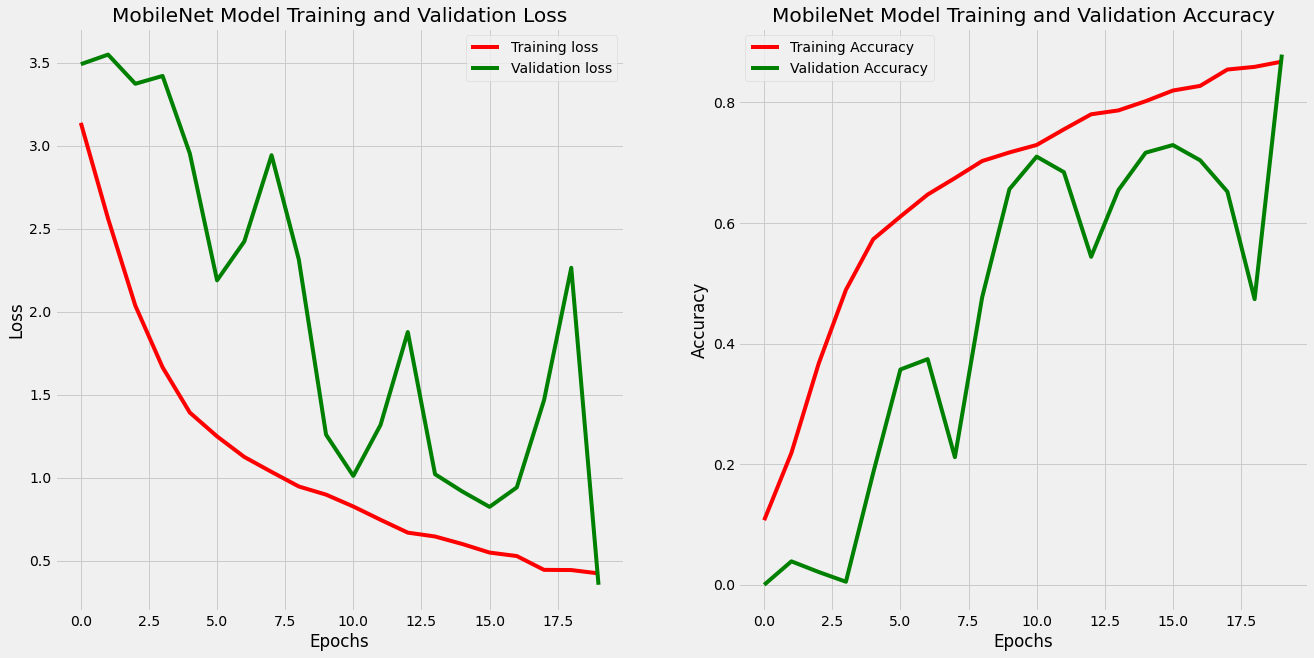

In [ ]:
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('MobileNet Model Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('MobileNet Model Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/MobileNet_model_graph.jpg")

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MobileNet.keras')

MobileNet 일부 층 Freeze

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
num = 1
for layer in base_model.layers:
  if num > 20:
    layer.trainable = True
  else:
    layer.trainable = False
  num += 1

In [ ]:
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))

model.add(base_model)

model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(33 , activation = 'softmax'))

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, 
optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

optimizer에서 learning rate를 적은 값을 주는 이유

https://durian9s-coding-tree.tistory.com/9

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 16)          147472    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 4, 4, 16)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 32)         

In [ ]:
hist = model.fit(train_ds,batch_size=64,epochs=20,validation_data=val_ds)

Epoch 1/20
124/124 [==============================] - 51s 391ms/step - loss: 2.5756 - accuracy: 0.2326 - val_loss: 3.2617 - val_accuracy: 0.1919
Epoch 2/20
124/124 [==============================] - 48s 385ms/step - loss: 1.7333 - accuracy: 0.4316 - val_loss: 2.8962 - val_accuracy: 0.2000
Epoch 3/20
124/124 [==============================] - 47s 383ms/step - loss: 1.5296 - accuracy: 0.5034 - val_loss: 1.6934 - val_accuracy: 0.5222
Epoch 4/20
124/124 [==============================] - 48s 386ms/step - loss: 1.5030 - accuracy: 0.5176 - val_loss: 3.3883 - val_accuracy: 0.1621
Epoch 5/20
124/124 [==============================] - 47s 380ms/step - loss: 1.4343 - accuracy: 0.5422 - val_loss: 2.7635 - val_accuracy: 0.2247
Epoch 6/20
124/124 [==============================] - 48s 385ms/step - loss: 1.3479 - accuracy: 0.5722 - val_loss: 2.3946 - val_accuracy: 0.3848
Epoch 7/20
124/124 [==============================] - 47s 382ms/step - loss: 1.3509 - accuracy: 0.5674 - val_loss: 1.9804 - val_ac

In [ ]:
model.evaluate(train_ds), model.evaluate(val_ds)

31/31 [==============================] - 2s 71ms/step - loss: 4.8064 - accuracy: 0.0783


([5.9306535720825195, 0.0886363610625267],
 [4.806406497955322, 0.07828282564878464])

DenseNet - learning_rate 0.0001

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))

model.add(base_model)

model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(33 , activation = 'softmax'))

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

In [ ]:
hist = model.fit(train_ds,batch_size=64,epochs=20,validation_data=val_ds)

Epoch 1/20
124/124 [==============================] - 107s 775ms/step - loss: 3.2677 - accuracy: 0.0934 - val_loss: 3.8486 - val_accuracy: 0.0000e+00
Epoch 2/20
124/124 [==============================] - 94s 762ms/step - loss: 2.1201 - accuracy: 0.3920 - val_loss: 4.2129 - val_accuracy: 0.0000e+00
Epoch 3/20
124/124 [==============================] - 94s 758ms/step - loss: 1.1971 - accuracy: 0.6528 - val_loss: 3.7801 - val_accuracy: 0.0621
Epoch 4/20
124/124 [==============================] - 94s 756ms/step - loss: 0.7086 - accuracy: 0.7869 - val_loss: 4.1205 - val_accuracy: 0.0354
Epoch 5/20
124/124 [==============================] - 94s 758ms/step - loss: 0.4507 - accuracy: 0.8606 - val_loss: 4.5651 - val_accuracy: 0.0247
Epoch 6/20
124/124 [==============================] - 94s 757ms/step - loss: 0.2909 - accuracy: 0.9129 - val_loss: 3.4584 - val_accuracy: 0.1859
Epoch 7/20
124/124 [==============================] - 94s 758ms/step - loss: 0.1893 - accuracy: 0.9424 - val_loss: 2.9416

In [ ]:
model.evaluate(train_ds), model.evaluate(val_ds)

31/31 [==============================] - 6s 189ms/step - loss: 0.1069 - accuracy: 0.9793


([0.029098330065608025, 0.9925504922866821],
 [0.10685364156961441, 0.9792929291725159])

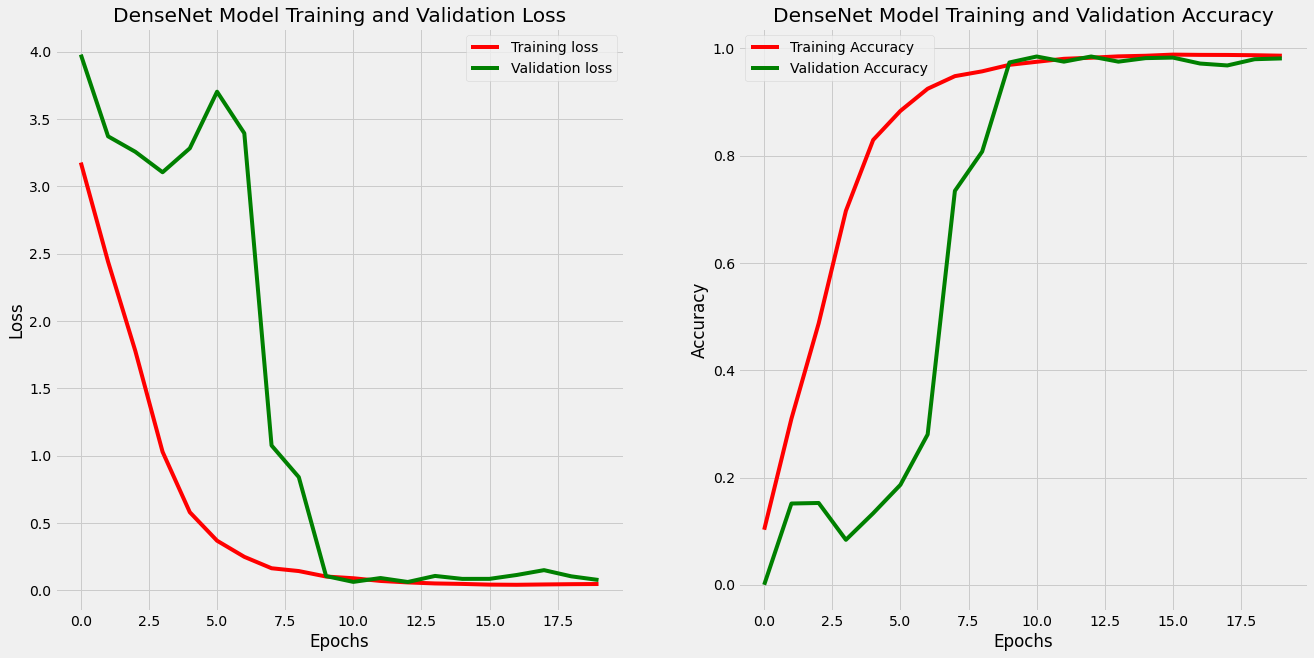

In [ ]:
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('DenseNet Model Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('DenseNet Model Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/DenseNet121_model_graph.jpg")

DenseNet으로 kaggle 데이터셋 학습해보기

In [ ]:
last_layer = model.get_layer('dense_13')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(20,activation='softmax')(x)

new_model3 = Model(model.input, x)

In [ ]:
for layer in new_model3.layers:
  layer.trainable = True

In [ ]:
new_model3.compile(loss=tf.keras.losses.categorical_crossentropy, 
optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
new_hist3 = new_model3.fit(train_ds2,batch_size=64,epochs=20,validation_data=val_ds2)

Epoch 1/20
41/41 [==============================] - 49s 945ms/step - loss: 2.9239 - accuracy: 0.0935 - val_loss: 2.9020 - val_accuracy: 0.0124
Epoch 2/20
41/41 [==============================] - 31s 750ms/step - loss: 2.8449 - accuracy: 0.1781 - val_loss: 2.8918 - val_accuracy: 0.0216
Epoch 3/20
41/41 [==============================] - 31s 747ms/step - loss: 2.7976 - accuracy: 0.2964 - val_loss: 2.8248 - val_accuracy: 0.0510
Epoch 4/20
41/41 [==============================] - 31s 754ms/step - loss: 2.7692 - accuracy: 0.3462 - val_loss: 2.8014 - val_accuracy: 0.0417
Epoch 5/20
41/41 [==============================] - 31s 754ms/step - loss: 2.7501 - accuracy: 0.3682 - val_loss: 2.7783 - val_accuracy: 0.0294
Epoch 6/20
41/41 [==============================] - 31s 758ms/step - loss: 2.7377 - accuracy: 0.3644 - val_loss: 2.7574 - val_accuracy: 0.0355
Epoch 7/20
41/41 [==============================] - 31s 754ms/step - loss: 2.7257 - accuracy: 0.3694 - val_loss: 2.7523 - val_accuracy: 0.0170

In [ ]:
new_model3.evaluate(train_ds2), new_model3.evaluate(val_ds2)

11/11 [==============================] - 2s 176ms/step - loss: 2.6929 - accuracy: 0.4420


([2.6268160343170166, 0.5293663144111633],
 [2.6929056644439697, 0.44204017519950867])

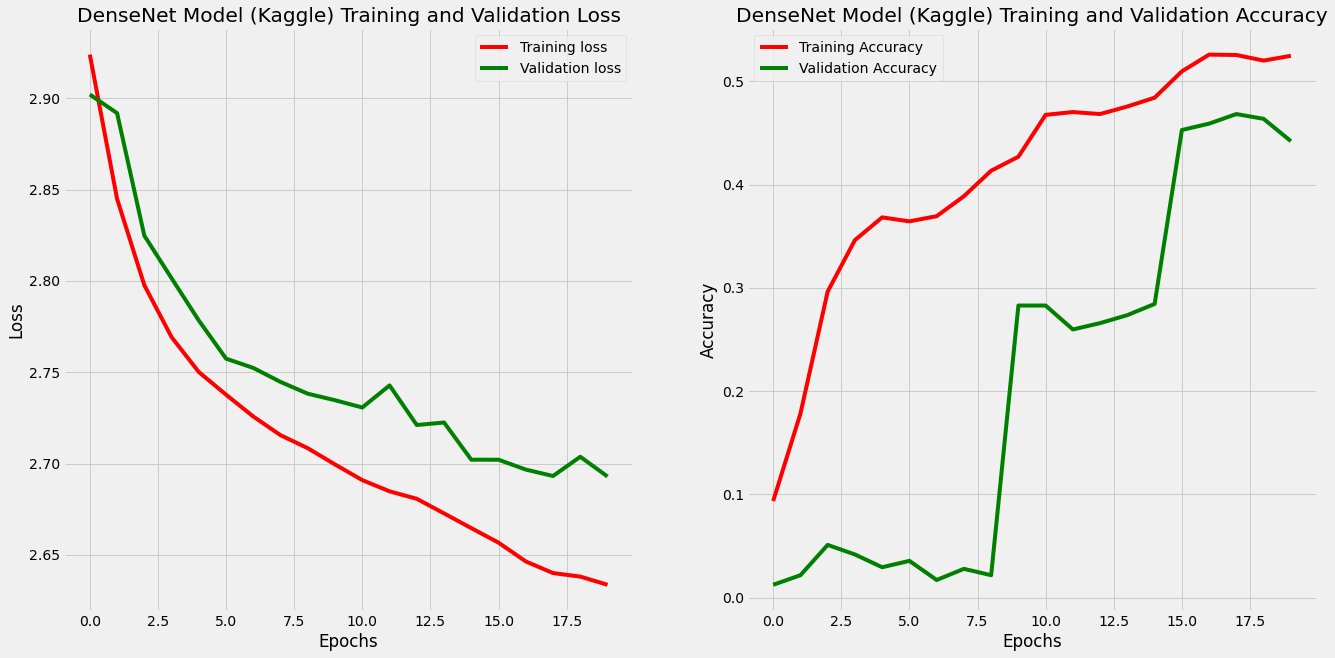

In [ ]:
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(new_hist3.history["loss"], 'r', label='Training loss')
axes[0].plot(new_hist3.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('DenseNet Model (Kaggle) Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (new_hist3.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (new_hist3.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('DenseNet Model (Kaggle) Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/DenseNet_model_kaggle_graph.jpg")

DenseNet kaggle 데이터셋 적용 - dense 층 하나 추가

In [ ]:
last_layer = model.get_layer('dense_13')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dense(20,activation='softmax')(x)

new_model4 = Model(model.input, x)

In [ ]:
for layer in new_model4.layers:
  layer.trainable = True

In [ ]:
new_model4.compile(loss=tf.keras.losses.categorical_crossentropy, 
optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
new_hist4 = new_model4.fit(train_ds2,batch_size=64,epochs=20,validation_data=val_ds2)

Epoch 1/20
41/41 [==============================] - 46s 806ms/step - loss: 2.9711 - accuracy: 0.0692 - val_loss: 2.9301 - val_accuracy: 0.1669
Epoch 2/20
41/41 [==============================] - 31s 758ms/step - loss: 2.9173 - accuracy: 0.2434 - val_loss: 2.9025 - val_accuracy: 0.1917
Epoch 3/20
41/41 [==============================] - 31s 746ms/step - loss: 2.8771 - accuracy: 0.3454 - val_loss: 2.9037 - val_accuracy: 0.1855
Epoch 4/20
41/41 [==============================] - 31s 764ms/step - loss: 2.8417 - accuracy: 0.3505 - val_loss: 2.8659 - val_accuracy: 0.1947
Epoch 5/20
41/41 [==============================] - 31s 756ms/step - loss: 2.8055 - accuracy: 0.3617 - val_loss: 2.8537 - val_accuracy: 0.1947
Epoch 6/20
41/41 [==============================] - 31s 748ms/step - loss: 2.7653 - accuracy: 0.3675 - val_loss: 2.8234 - val_accuracy: 0.1870
Epoch 7/20
41/41 [==============================] - 31s 760ms/step - loss: 2.7251 - accuracy: 0.3628 - val_loss: 2.8515 - val_accuracy: 0.1700

In [ ]:
new_model4.evaluate(train_ds2), new_model4.evaluate(val_ds2)

In [ ]:
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(new_hist4.history["loss"], 'r', label='Training loss')
axes[0].plot(new_hist4.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('DenseNet Model (Kaggle) Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (new_hist4.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (new_hist4.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('DenseNet Model (Kaggle) Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/DenseNet_model_kaggle2_graph.jpg")

MobileNet learning rate 0.0001

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))

model.add(base_model)

model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(33 , activation = 'softmax'))

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, 
optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
hist = model.fit(train_ds,batch_size=64,epochs=20,validation_data=val_ds)

Epoch 1/20
124/124 [==============================] - 53s 401ms/step - loss: 3.4256 - accuracy: 0.0559 - val_loss: 3.5439 - val_accuracy: 0.0000e+00
Epoch 2/20
124/124 [==============================] - 48s 388ms/step - loss: 2.7394 - accuracy: 0.2246 - val_loss: 3.6299 - val_accuracy: 0.0101
Epoch 3/20
124/124 [==============================] - 49s 392ms/step - loss: 1.8272 - accuracy: 0.4848 - val_loss: 2.9920 - val_accuracy: 0.1354
Epoch 4/20
124/124 [==============================] - 48s 390ms/step - loss: 1.2843 - accuracy: 0.6335 - val_loss: 1.9862 - val_accuracy: 0.4697
Epoch 5/20
124/124 [==============================] - 49s 391ms/step - loss: 0.9391 - accuracy: 0.7212 - val_loss: 1.1921 - val_accuracy: 0.6525
Epoch 6/20
124/124 [==============================] - 48s 389ms/step - loss: 0.6746 - accuracy: 0.7931 - val_loss: 0.7646 - val_accuracy: 0.7530
Epoch 7/20
124/124 [==============================] - 48s 389ms/step - loss: 0.4717 - accuracy: 0.8583 - val_loss: 0.2583 - va

In [ ]:
model.evaluate(train_ds), model.evaluate(val_ds)

31/31 [==============================] - 2s 70ms/step - loss: 0.1729 - accuracy: 0.9652


([0.017806528136134148, 0.995707094669342],
 [0.17289325594902039, 0.9651514887809753])

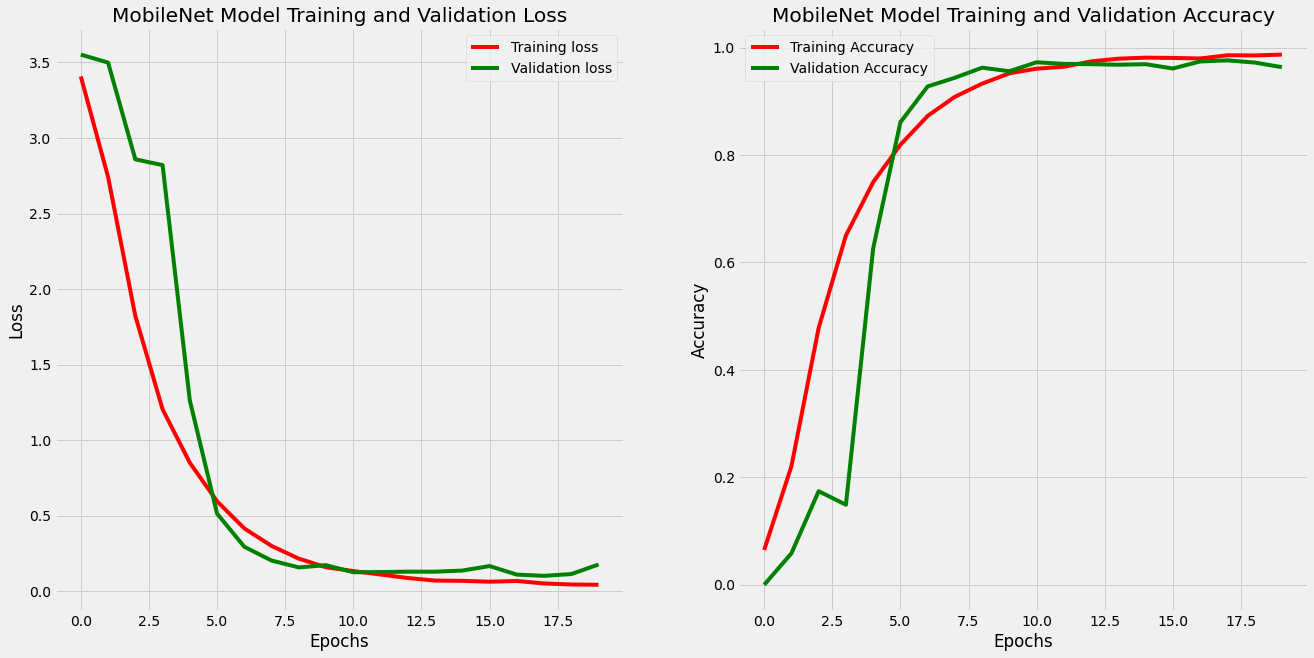

In [ ]:
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('MobileNet Model Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('MobileNet Model Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/MobileNet(lr=0.0001)_model_graph.jpg")

MobileNet으로 kaggle 데이터셋 학습

In [ ]:
last_layer = model.get_layer('dense_10')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(20,activation='softmax')(x)

new_model2 = Model(model.input, x)

In [ ]:
for layer in new_model2.layers:
  layer.trainable = True

In [ ]:
new_model2.compile(loss=tf.keras.losses.categorical_crossentropy, 
optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
new_hist2 = new_model2.fit(train_ds2,batch_size=64,epochs=20,validation_data=val_ds2)

Epoch 1/20
41/41 [==============================] - 21s 444ms/step - loss: 2.9605 - accuracy: 0.0958 - val_loss: 2.9389 - val_accuracy: 0.0819
Epoch 2/20
41/41 [==============================] - 16s 398ms/step - loss: 2.8839 - accuracy: 0.1824 - val_loss: 2.9098 - val_accuracy: 0.0958
Epoch 3/20
41/41 [==============================] - 17s 405ms/step - loss: 2.8421 - accuracy: 0.2094 - val_loss: 2.8844 - val_accuracy: 0.0804
Epoch 4/20
41/41 [==============================] - 16s 386ms/step - loss: 2.8130 - accuracy: 0.2519 - val_loss: 2.8359 - val_accuracy: 0.0572
Epoch 5/20
41/41 [==============================] - 16s 386ms/step - loss: 2.7901 - accuracy: 0.3234 - val_loss: 2.8255 - val_accuracy: 0.0819
Epoch 6/20
41/41 [==============================] - 16s 389ms/step - loss: 2.7728 - accuracy: 0.3393 - val_loss: 2.7979 - val_accuracy: 0.0726
Epoch 7/20
41/41 [==============================] - 16s 391ms/step - loss: 2.7601 - accuracy: 0.3543 - val_loss: 2.7869 - val_accuracy: 0.0541

In [ ]:
new_model2.evaluate(train_ds2), new_model2.evaluate(val_ds2)

11/11 [==============================] - 1s 66ms/step - loss: 2.6892 - accuracy: 0.0077


([2.6478490829467773, 0.36089643836021423],
 [2.68923020362854, 0.007727975491434336])

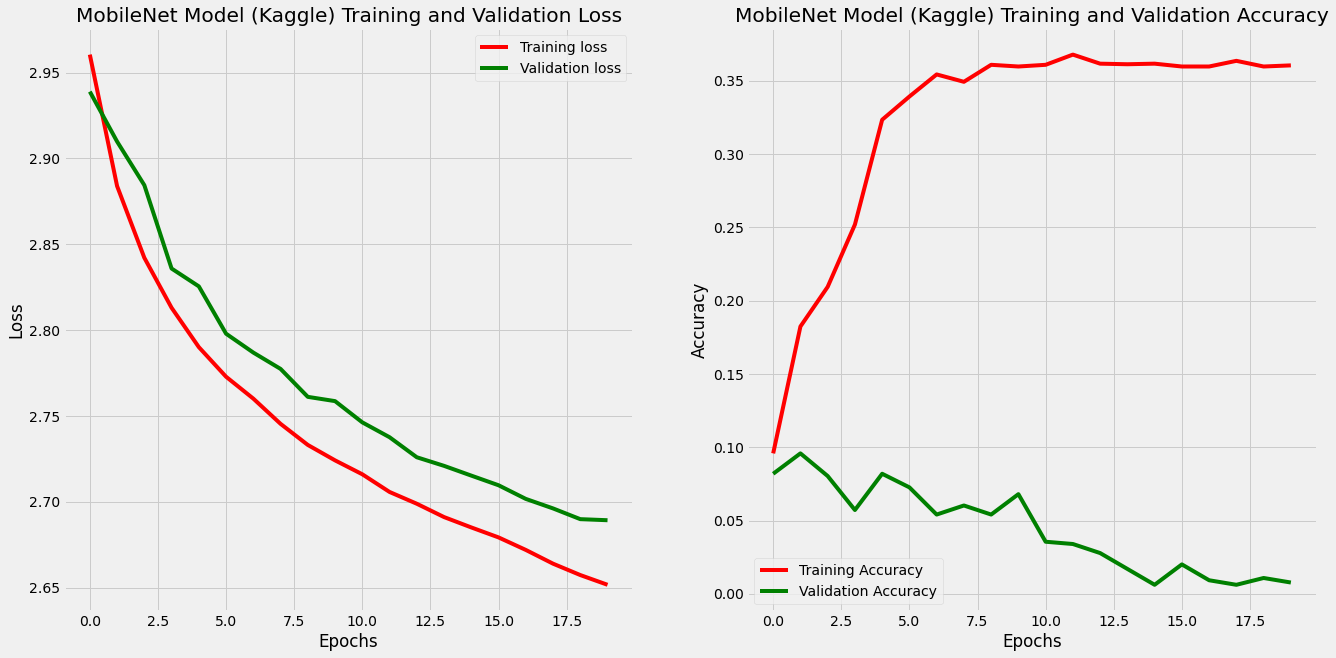

In [ ]:
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(new_hist2.history["loss"], 'r', label='Training loss')
axes[0].plot(new_hist2.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('MobileNet Model (Kaggle) Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (new_hist2.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (new_hist2.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('MobileNet Model (Kaggle) Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/MobileNet_model_kaggle_graph.jpg")

ResNet50 learning rate 0.0001

In [ ]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))

model.add(base_model)

model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(33 , activation = 'softmax'))

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, 
optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
hist = model.fit(train_ds,batch_size=64,epochs=20,validation_data=val_ds)

Epoch 1/20
124/124 [==============================] - 100s 735ms/step - loss: 3.3033 - accuracy: 0.0823 - val_loss: 3.5630 - val_accuracy: 0.0000e+00
Epoch 2/20
124/124 [==============================] - 86s 691ms/step - loss: 2.0617 - accuracy: 0.4201 - val_loss: 4.3576 - val_accuracy: 0.0000e+00
Epoch 3/20
124/124 [==============================] - 86s 695ms/step - loss: 1.2277 - accuracy: 0.6485 - val_loss: 4.4823 - val_accuracy: 0.0000e+00
Epoch 4/20
124/124 [==============================] - 86s 694ms/step - loss: 0.8368 - accuracy: 0.7542 - val_loss: 4.1147 - val_accuracy: 0.0000e+00
Epoch 5/20
124/124 [==============================] - 86s 692ms/step - loss: 0.5600 - accuracy: 0.8311 - val_loss: 4.2145 - val_accuracy: 0.0000e+00
Epoch 6/20
124/124 [==============================] - 86s 694ms/step - loss: 0.3837 - accuracy: 0.8867 - val_loss: 4.7127 - val_accuracy: 0.0000e+00
Epoch 7/20
124/124 [==============================] - 86s 691ms/step - loss: 0.2669 - accuracy: 0.9227 - 

In [ ]:
model.evaluate(train_ds), model.evaluate(val_ds)

31/31 [==============================] - 6s 205ms/step - loss: 0.3350 - accuracy: 0.9121


([0.35516515374183655, 0.9191918969154358],
 [0.3350241780281067, 0.9121212363243103])

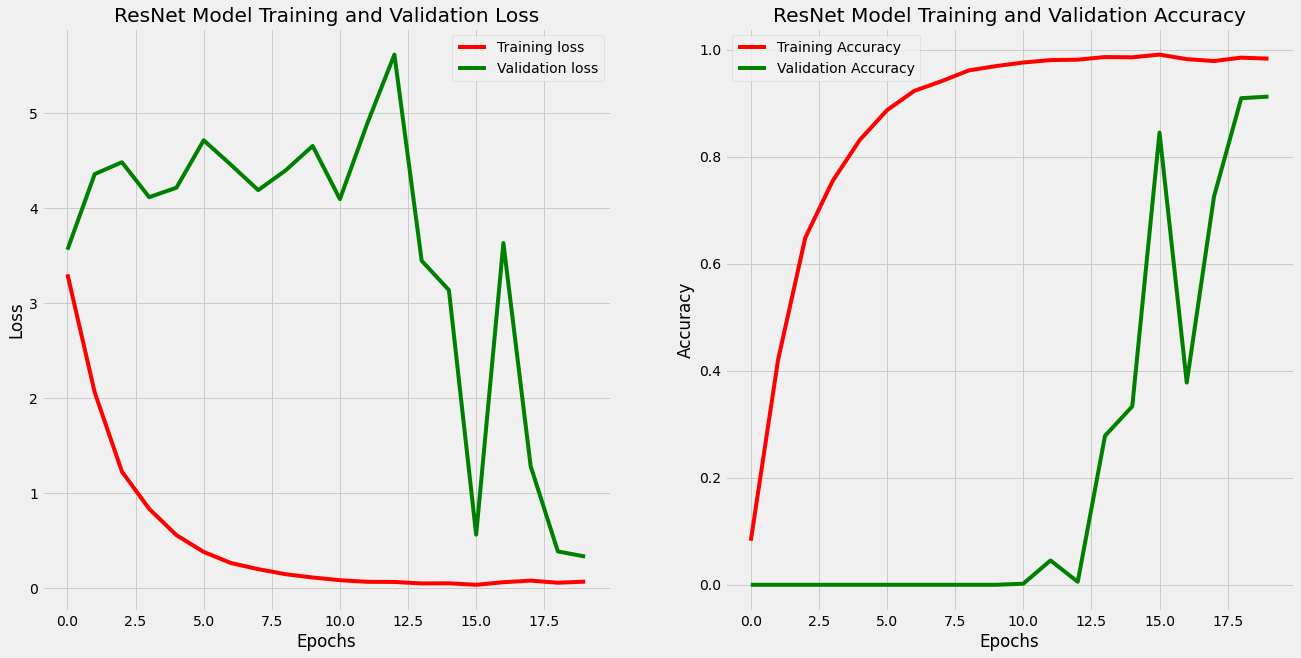

In [ ]:
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('ResNet Model Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('ResNet Model Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/ResNet_model_graph.jpg")

ResNet으로 kaggle 데이터셋 학습

In [ ]:
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/cars.zip" -d "/content/drive/MyDrive/Colab Notebooks/Car Kaggle"

In [ ]:
data_dir2 = '/content/drive/MyDrive/Colab Notebooks/Car Kaggle/cars'

train_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir2,
    validation_split=0.2,
    subset='training',
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    seed=123,
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

val_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir2,
    validation_split=0.2,
    subset='validation',
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    seed=123,
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds2 = (train_ds2.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))
val_ds2 = (val_ds2.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))

Found 3235 files belonging to 20 classes.
Using 2588 files for training.
Found 3235 files belonging to 20 classes.
Using 647 files for validation.


In [ ]:
last_layer = model.get_layer('dense_7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(20,activation='softmax')(x)

new_model = Model(model.input, x)

In [ ]:
for layer in new_model.layers:
  layer.trainable = True

In [ ]:
new_model.compile(loss=tf.keras.losses.categorical_crossentropy, 
optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
new_hist = new_model.fit(train_ds2,batch_size=64,epochs=20,validation_data=val_ds2)

Epoch 1/20
41/41 [==============================] - 41s 820ms/step - loss: 2.9455 - accuracy: 0.1291 - val_loss: 2.8642 - val_accuracy: 0.1901
Epoch 2/20
41/41 [==============================] - 28s 676ms/step - loss: 2.8536 - accuracy: 0.2442 - val_loss: 2.8331 - val_accuracy: 0.2844
Epoch 3/20
41/41 [==============================] - 29s 700ms/step - loss: 2.8104 - accuracy: 0.3292 - val_loss: 2.7869 - val_accuracy: 0.3787
Epoch 4/20
41/41 [==============================] - 29s 698ms/step - loss: 2.7951 - accuracy: 0.3512 - val_loss: 2.7936 - val_accuracy: 0.3524
Epoch 5/20
41/41 [==============================] - 28s 675ms/step - loss: 2.7784 - accuracy: 0.3717 - val_loss: 2.7750 - val_accuracy: 0.3972
Epoch 6/20
41/41 [==============================] - 28s 687ms/step - loss: 2.7657 - accuracy: 0.3914 - val_loss: 2.7697 - val_accuracy: 0.4343
Epoch 7/20
41/41 [==============================] - 28s 692ms/step - loss: 2.7506 - accuracy: 0.4208 - val_loss: 2.7477 - val_accuracy: 0.4359

In [ ]:
new_model.evaluate(train_ds2), new_model.evaluate(val_ds2)

11/11 [==============================] - 2s 194ms/step - loss: 2.6886 - accuracy: 0.4204


([2.701451301574707, 0.45788252353668213],
 [2.6886215209960938, 0.42040184140205383])

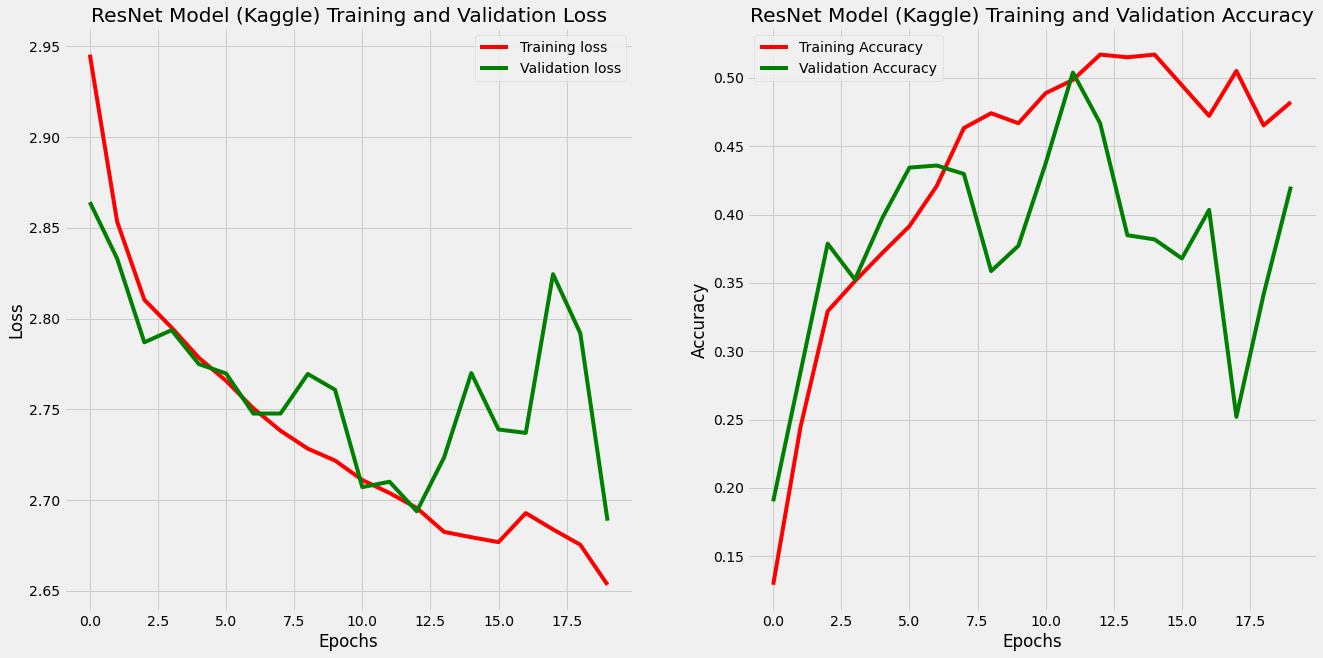

In [ ]:
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(new_hist.history["loss"], 'r', label='Training loss')
axes[0].plot(new_hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('ResNet Model (Kaggle) Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (new_hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (new_hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('ResNet Model (Kaggle) Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/ResNet_model_kaggle_graph.jpg")